In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')
from UZ_utils import *

sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/assignment4')
from a4_utils import *

Mounted at /content/drive


In [ ]:
def gaussian(o=2):
  N = int(np.ceil(3*o))
  k = np.zeros(2*N+1)
  inter = np.arange(-N,N+1)
  return 1/(np.sqrt(2*np.pi)*o) * np.exp(-1*(np.square(inter)/(2*o*o)))

def gaussdx(o=2):
  N = int(np.ceil(3*o))
  k = np.zeros(2*N+1)
  inter = np.arange(-N,N+1)
  not_normal = -1/(np.sqrt(2*np.pi)*o*o*o)*inter * np.exp(-1*(np.square(inter)/(2*o*o)))
  #not_normal = -1* not_normal # flip kernel as it is not symmetric
  return not_normal/np.sum(np.abs(not_normal))

def filter(I, kernel2D):
  I_k = cv2.filter2D(src=I, ddepth=-1, kernel = kernel2D)
  return I_k

def get_G_D(o):
  G = -1*gaussian(o)
  G = G.reshape(1,len(G))
  D = gaussdx(o)
  D = D.reshape(1,len(D))
  return (G,D)

def part_deriv_x(I,o):
  G,D = get_G_D(o)
  return filter(filter(I, G.T),D) # x

def part_deriv_y(I,o):
  G,D = get_G_D(o)
  return filter(filter(I, G),D.T) # y

def part_deriv_x_x(I,o):
  G,D = get_G_D(o)
  return part_deriv_x(part_deriv_x(I,o),o) # x x

def part_deriv_y_y(I,o):
  G,D = get_G_D(o)
  return part_deriv_y(part_deriv_y(I,o),o) # y y

def part_deriv_x_y(I,o):
  G,D = get_G_D(o)
  return part_deriv_x(part_deriv_y(I,o),o) # x y

###########################################33
def gradient_magnitude(I,o): # I = gray
  Ix = part_deriv_x(I,o)
  Iy = part_deriv_y(I,o)
  M = np.sqrt(np.multiply(Ix,Ix)+np.multiply(Iy,Iy))
  A = np.arctan2(Iy,Ix)
  return (M,A)



 EX 1a

Bigger sigma bigger dots are detected.

In [ ]:
def loc_max_box(A,y,x,box_size=1):#9,25
  if box_size == 1:
    return (A[y,x] >= max(A[y+1,x-1],A[y+1,x+1],A[y+1,x],A[y,x+1]) and A[y,x] > max(A[y,x-1],A[y-1,x-1],A[y-1,x],A[y-1,x+1]))
  elif box_size == 2:
    return (A[y,x] > max(A[y-2,x-2], A[y-2,x-1], A[y-2,x], A[y-2,x+1], A[y-2,x+2],
                         A[y-1,x-2], A[y-1,x-1], A[y-1,x], A[y-1,x+1], A[y-1,x+2],
                         A[y,x-2],   A[y,x-1]) and
            A[y,x] >= max(A[y,x+1], A[y,x+2],
                          A[y+1,x-2], A[y+1,x-1], A[y+1,x], A[y+1,x+1], A[y+1,x+2],
                          A[y+2,x-2], A[y+2,x-1], A[y+2,x], A[y+2,x+1], A[y+2,x+2]))


def nonmaxima_suppression_box(A,box_size=2):
  A_ = np.copy(A)
  for x in range(box_size,len(A[0])-box_size):
    for y in range(box_size,len(A)-box_size):
      if not loc_max_box(A_,y,x,box_size):
        A_[y,x] = 0
  return(A_)

def points_nonmax_tresh(hp,tresh=0.5,box_size=2):
  I = nonmaxima_suppression_box(hp,box_size)
  I = np.where(I>tresh,1,0)
  return(I)

def get_points(hpnt):
  X = []
  Y = []
  for y in range(len(hpnt)):
    for x in range(len(hpnt[0])):
      if hpnt[y,x] > 0:
        X.append(x)
        Y.append(y)
  X = np.array(X)
  Y = np.array(Y)
  return (X,Y)

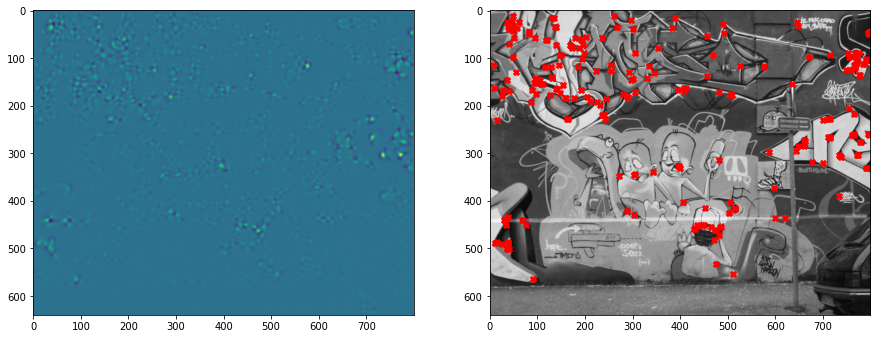

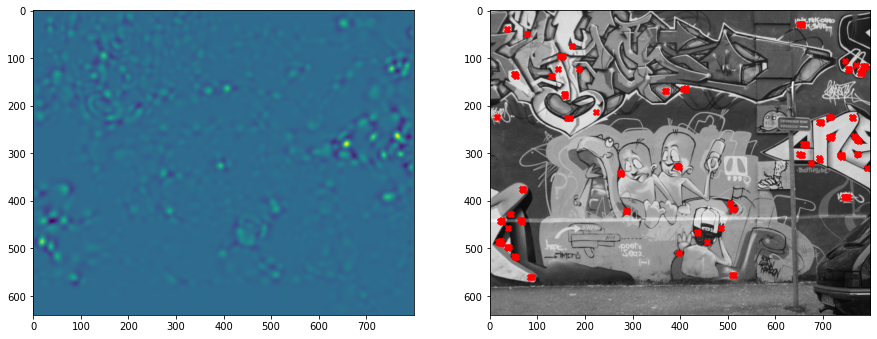

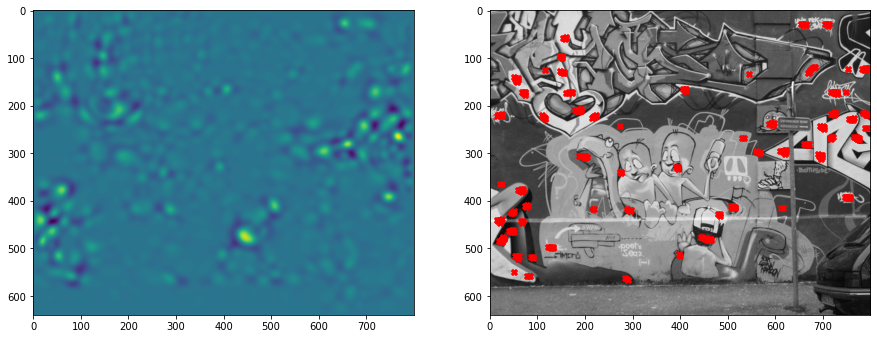

In [ ]:
def hessian_points(I,o):
  Ixx = part_deriv_x_x(I,o)
  Iyy = part_deriv_y_y(I,o)
  Ixy = part_deriv_x_y(I,o)

  R = np.multiply(Ixx,Iyy) - np.multiply(Ixy,Ixy)
  R = R-np.amin(R)
  R = R/np.amax(R)
  return(R)
        

I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a.jpg')
#imshow(I)
tresh = 0.5
for o in [3,6,9]:
  _, ax = plt.subplots(1,2,figsize=(15, 15))
  hp = hessian_points(I,o)
  ax[0].imshow(hp, cmap="viridis")
  #ax[1].imshow(hessian_points_nonmax_tresh(I,o,tresh), cmap="viridis")
  hpnt = points_nonmax_tresh(hp,tresh,box_size=2)
  #ax[1].imshow(hpnt, cmap="viridis")
  ax[1].imshow(I,cmap="gray")
  X,Y = get_points(hpnt)
  ax[1].scatter(X,Y,color="red",marker='X')





#I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/images/test_points.jpg')



EX 1b

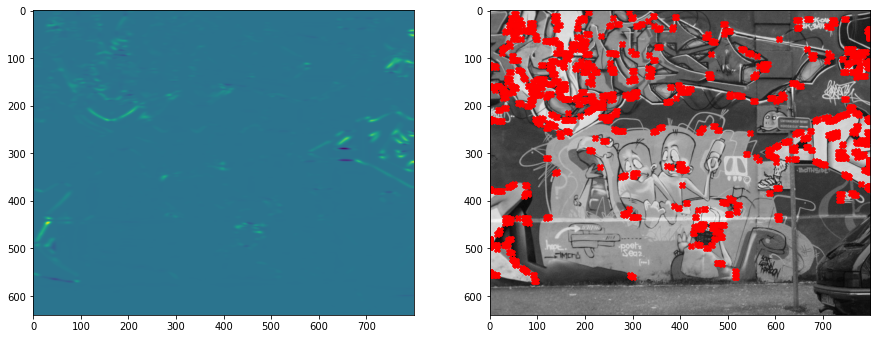

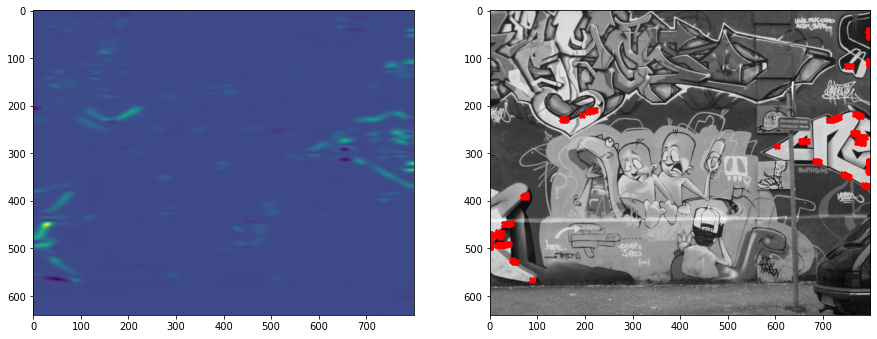

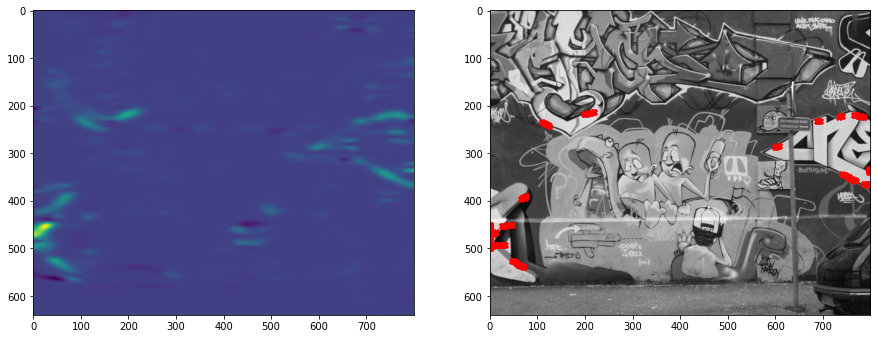

In [ ]:
def harris_points(I,o):
  Ix = part_deriv_x(I,o)
  Iy = part_deriv_y(I,o)

  o2 = 1.6*o
  G,_ = get_G_D(o2)

  a = filter(Ix*Ix,G)
  d = filter(Iy*Iy,G)

  det = np.multiply(a,d)
  trace = a+d

  alfa = 0.06
  R = det - alfa * np.multiply(trace,trace)
  R = R-np.amin(R)
  R = R/np.amax(R)
  return(R)


I = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a.jpg')
#imshow(I)
tresh = 0.4
for o in [3,6,9]:
  _, ax = plt.subplots(1,2,figsize=(15, 15))
  hp = harris_points(I,o)
  ax[0].imshow(hp,cmap="viridis")
  #ax[1].imshow(hessian_points_nonmax_tresh(I,o,tresh), cmap="viridis")
  hpnt = points_nonmax_tresh(hp,tresh,box_size=2)
  #ax[1].imshow(hpnt, cmap="viridis")
  ax[1].imshow(I,cmap="gray")
  X,Y = get_points(hpnt)
  ax[1].scatter(X,Y,color="red",marker='X')



EX 2a OK

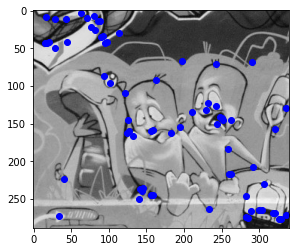

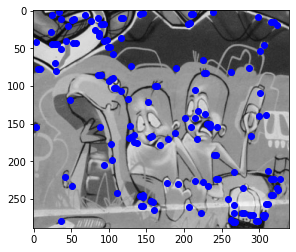

In [ ]:
tresh = 0.5
o = 3
radius = 40#80
sigma = 2#10
n_bins = 16#32

I1 = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a_small.jpg')
hp = hessian_points(I1,o)
hpnt = points_nonmax_tresh(hp,tresh,box_size=2)
X1,Y1 = get_points(hpnt)
plt.imshow(I1,cmap="gray")
plt.scatter(X1,Y1,color="blue",marker='o')
descA = simple_descriptors(I1,Y1,X1,radius=radius,sigma=sigma)

plt.show()


I2 = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_b_small.jpg')
hp = hessian_points(I2,o)
hpnt = points_nonmax_tresh(hp,tresh,box_size=2)
X2,Y2 = get_points(hpnt)
plt.imshow(I2,cmap="gray")
plt.scatter(X2,Y2,color="blue",marker='o')
descB = simple_descriptors(I2,Y2,X2,radius=radius,sigma=sigma)


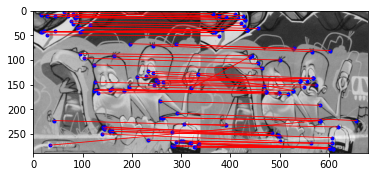

In [ ]:
def hell_dist(v1,v2):
  return np.sqrt(1/2 * np.sum(np.square(np.sqrt(v1)-np.sqrt(v2))))

def find_correspondences(descA,descB):
  corr = np.zeros((len(descA),len(descB)))
  for i in range(len(descA)):
    for j in range(len(descB)):
      corr[i,j] = hell_dist(descA[i],descB[j])

  a = np.arange(len(descA))
  b = np.argmin(corr, axis=1)
  ab = np.column_stack((a,b))
  #print(ab)
  return(ab)
  

ab = find_correspondences(descA,descB)
xy1 = np.column_stack((X1,Y1))[ab[:,0]]
xy2 = np.column_stack((X2,Y2))[ab[:,1]]

display_matches(I1,xy1,I2,xy2)


EX 2b

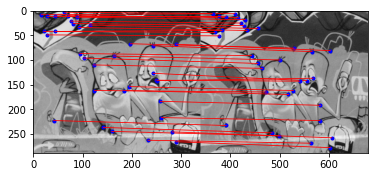

In [ ]:
def find_matches(Ia,Ib):
  X1,Y1 = get_points(points_nonmax_tresh(hessian_points(Ia,o)))
  descA = simple_descriptors(Ia,Y1,X1)

  X2,Y2 = get_points(points_nonmax_tresh(hessian_points(Ib,o)))
  descB = simple_descriptors(Ib,Y2,X2)

  ab = find_correspondences(descA,descB)
  #print(ab)
  ba = find_correspondences(descB,descA)
  #print(ba)
  ab_ = ba[:,np.array([1,0])]
  r = []
  for i in range(len(ab)):
    for j in range(len(ab_)):
      if ab[i,0] == ab_[j,0] and ab[i,1] == ab_[j,1]:
        r.append(ab[i,:])
        break
  
  matches = np.array(r)
  xy1 = np.column_stack((X1,Y1))[matches[:,0]]
  xy2 = np.column_stack((X2,Y2))[matches[:,1]]
  display_matches(Ia,xy1,Ib,xy2)
  points = np.column_stack((xy1,xy2))
  return points

Ia = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a_small.jpg')
Ib = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_b_small.jpg')
points = find_matches(Ia,Ib)
#print(points)


EX 2c*

EX 2d*

<BarContainer object of 576 artists>

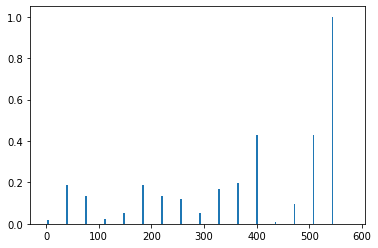

In [ ]:
def g(x,l):
  N = int(l/2)
  o = N/3
  g = 1/(np.sqrt(2*np.pi)*o) * np.exp(-1*(np.square(x)/(2*o*o)))
  return g


def sift_hist(I,o,dangle,n_angle_bins=8,pcs=4):
  M, A = gradient_magnitude(I,o)

  v_unit = int(I.shape[0]//pcs)
  h_unit = int(I.shape[1]//pcs)
  

  H_ = []
  for v in range(pcs):
    for h in range(pcs):
      H = np.zeros(n_angle_bins)
      for y in range(v_unit):
        for x in range(h_unit):
          y_ = v*pcs+y
          x_ = h*pcs+x
          #print(y_,x_)
          a_bin = int(np.floor((A[y_,x_]+dangle)%(2*np.pi/n_angle_bins))) #(4),3 ... 1,0,-1 .. -4
          a_bin = 3 if a_bin == 4 else a_bin
          a_bin += 4 #0,...7
          H[a_bin] += M[y_,x_] * g(x,h_unit) * g(y,v_unit)
      #print(H)
      H_ = np.concatenate([H_,H])
  H_ = H_/np.amax(H_)
  return(H_)



def sift(I,x,y,d,o=5):
  region = I[y-d:y+d+1,x-d:x+d+1]
  g = gaussian(d)
  n_angle_bins=36
  grad_h = sift_hist(region,o,dangle=0,n_angle_bins=n_angle_bins,pcs=1)
  ix_maxgrad = np.where(grad_h > 0.8)
  for a_bin in ix_maxgrad:
    dangle = (a_bin-4)*(2*np.pi/n_angle_bins)
    hist = sift_hist(region,o,dangle,n_angle_bins)
    return(hist)

def sift_v(I,Y,X,d=10):
  hists = []
  for i in range(len(X)):
    #print(X[i],Y[i])
    hists.append(sift(I,X[i],Y[i],d))
  return(np.array(hists))


Ia = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a_small.jpg')
hist= sift(Ia,50,50,d=10)
plt.bar(np.arange(len(hist)),hist,width=3)





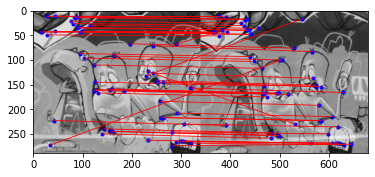

[[ 28  11  36  11]
 [ 43  11  51  12]
 [ 88  13  93  17]
 [ 85  14  90  18]
 [ 76  21  81  25]
 [ 81  26  87  30]
 [114  29 116  36]
 [ 92  34  97  39]
 [ 89  35  94  40]
 [ 44  42  53  43]
 [ 98  42 102  48]
 [ 15  43  25  44]
 [ 18  43  28  44]
 [ 95  43  99  48]
 [ 28  49  37  51]
 [197  67 189  76]
 [290  68  43  40]
 [243  71 226  83]
 [ 94  87 100  93]
 [163  92 161 100]
 [102  96 107 103]
 [122 110 125 117]
 [232 123 192 230]
 [243 127 228 137]
 [229 132 205  17]
 [251 142 234 151]
 [126 145 128 153]
 [252 145 234 154]
 [263 145 244 154]
 [321 157 289 166]
 [159 159 158 167]
 [127 160 130 168]
 [156 160 155 168]
 [124 162 127 169]
 [183 162 178 170]
 [132 167 134 175]
 [258 184 240 192]
 [292 208 267 215]
 [260 217 242 223]
 [263 217 245 223]
 [ 41 223  51 233]
 [306 230 278 236]
 [144 240 145 248]
 [156 245 156 253]
 [159 245 159 254]
 [282 246 259 250]
 [140 250 143 259]
 [233 263 223 269]
 [300 265 277 269]
 [303 265 280 269]
 [289 266 267 269]
 [321 269 291 272]
 [ 34 273 16

In [ ]:
def discard_edge_pixels(I,X,Y,d):
  mask = (d<X) & (X+d+1<(len(I[0]))) & (d<Y) & (Y+d+1<(len(I)))
  X_ = X[mask]
  Y_ = Y[mask]

  return((X_,Y_))


def find_matches_sift(Ia,Ib,d=10):
  X1,Y1 = get_points(points_nonmax_tresh(hessian_points(Ia,o)))
  X1,Y1 = discard_edge_pixels(Ia,X1,Y1,d)
  descA = sift_v(Ia,Y1,X1,d)

  X2,Y2 = get_points(points_nonmax_tresh(hessian_points(Ib,o)))
  X2,Y2 = discard_edge_pixels(Ia,X2,Y2,d)
  descB = sift_v(Ib,Y2,X2,d)

  ab = find_correspondences(descA,descB)
  #print(ab)
  ba = find_correspondences(descB,descA)
  #print(ba)
  ab_ = ba[:,np.array([1,0])]
  r = []
  for i in range(len(ab)):
    for j in range(len(ab_)):
      if ab[i,0] == ab_[j,0] and ab[i,1] == ab_[j,1]:
        r.append(ab[i,:])
        break
  
  matches = np.array(r)
  xy1 = np.column_stack((X1,Y1))[matches[:,0]]
  xy2 = np.column_stack((X2,Y2))[matches[:,1]]
  display_matches(Ia,xy1,Ib,xy2)
  points = np.column_stack((xy1,xy2))
  return points

Ia = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a_small.jpg')
Ib = imread_gray('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_b_small.jpg')
points = find_matches_sift(Ia,Ib)
print(points)

EX 2e* DELA

In [ ]:
def draw_keypoints(imagegray):
  features = cv2.SIFT_create()
  keypoints = features.detect(imagegray, None)
  
  output_image = cv2.drawKeypoints(imagegray, keypoints, 0, (0, 255, 0),
                                  flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
  return(output_image)


vidcap = cv2.VideoCapture('/content/drive/MyDrive/ColabNotebooks/assignment4/data/luc.webm')
success,image = vidcap.read()
count = 0
im_list = []
while success:
  #cv2.imwrite("frame%d.jpg" % count, image)     
  success,image = vidcap.read()
  if not success: break
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  keys = draw_keypoints(gray)

  im_list.append(keys)
  count += 1




# imagegray = cv2.imread('/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a_small.jpg', cv2.IMREAD_GRAYSCALE)
# I_keys = draw_keypoints(imagegray)
# imshow(I_keys)

In [ ]:
w,h,_ = im_list[0].shape
out = cv2.VideoWriter('/content/drive/MyDrive/ColabNotebooks/assignment4/data/video_related/project1.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (h,w))

l = len(im_list)
for i in range(l):
  #print("*",end="")
  out.write(im_list[i])
out.release()

EX 3a DELA

In [ ]:
def estimate_homography(R,T):
  Xr = R[:,0]
  Yr = R[:,1]
  Xt = T[:,0]
  Yt = T[:,1]
  A = np.zeros((len(Xr)*2, 9))
  for i in range(len(Xr)):
    A[i*2,:] = np.array([Xr[i], Yr[i], 1, 0, 0, 0, -Xt[i]*Xr[i], -Xt[i]*Yr[i], -Xt[i]])
    A[i*2+1,:] = np.array([0, 0, 0, Xr[i], Yr[i], 1, -Yt[i]*Xr[i], -Yt[i]*Yr[i], -Yt[i]])
  _, _, VT = np.linalg.svd(A)
  h = VT[-1,:]
  h = h / VT[-1,-1]
  H = h.reshape((3,3))
  #print(H)
  return(H)


RT = np.loadtxt("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork.txt")
R = RT[:,0:2]
T = RT[:,2:]
Ia = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork_a.jpg")
Ib = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork_b.jpg")

display_matches(Ia,R,Ib,T)
H = estimate_homography(R,T)
#H = cv2.getPerspectiveTransform(np.float32(R),np.float32(T))

dst = cv2.warpPerspective(Ia, H, dsize= (Ia.shape[1], Ia.shape[0]))
imshow(dst)







RT = np.loadtxt("/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf.txt")
R = RT[:,0:2]
T = RT[:,2:]
Ia = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_a.jpg")
Ib = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/graf/graf_b.jpg")

display_matches(Ia,R,Ib,T)
H = estimate_homography(R,T)
H = cv2.getPerspectiveTransform(np.float32(R),np.float32(T))
#print(H)
dst = cv2.warpPerspective(Ia, H, dsize= (Ia.shape[1], Ia.shape[0]))
imshow(dst)

NameError: ignored

EX 3b DELA

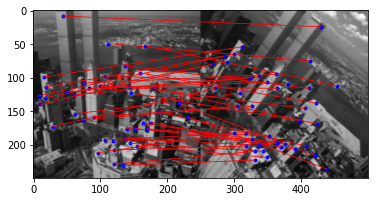

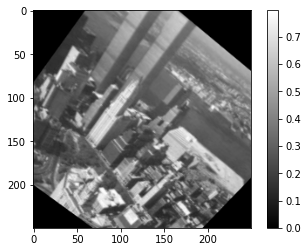

In [ ]:
import random
def estimate_homography(R,T):
  try:
    H = cv2.getPerspectiveTransform(np.float32(R),np.float32(T))
  except:
    return(None)
  return(H)

def inliers(R,T,H,area):
  ins = []
  for i in range(len(R)):
    x = np.array([[R[i,0],R[i,1],1]])
    x_ = H.dot(x.T)
    x_ = (x_/x_[-1])[:2]
    y = np.array([T[i,0],T[i,1]])
    err = np.sum(np.power(x_ - y,2))
    #print(err)
    if err <= area:
      ins.append(i)
  #errors = np.power(H*R-T,2) #..............
  #return(np.which(errors <= area))
  return(ins)

def ransac(R,T,n=10,area=10000,enough_inliers=len(R)*0.8):
  insl_H = None
  for k in range(n):
    s = random.sample(range(len(R)),4)
    H = estimate_homography(R[s],T[s])
    if H is None: continue
    ins = inliers(R,T,H,area)
    if len(ins) >= enough_inliers:
      #print("*")
      H = estimate_homography(R[ins], T[ins])
      if H is None: continue
      ins = inliers(R,T,H,tresh)
    #else:
      #print("**")
    if insl_H is None or insl_H[0] < len(ins):
      insl_H = (len(ins),H)
  return insl_H[1]



# RT = np.loadtxt("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork.txt")
# R = RT[:,0:2]
# T = RT[:,2:]
# Ia = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork_a.jpg")
# Ib = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork_b.jpg")

# display_matches(Ia,R,Ib,T)
# H = ransac(R,T)
# dst = cv2.warpPerspective(Ia, H, dsize= (Ia.shape[1], Ia.shape[0]))
# imshow(dst)


Ia = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork_a.jpg")
Ib = imread_gray("/content/drive/MyDrive/ColabNotebooks/assignment4/data/newyork/newyork_b.jpg")
RT = find_matches(Ia,Ib)
R = RT[:,0:2]
T = RT[:,2:]
#display_matches(Ia,R,Ib,T)
H = ransac(R,T)
dst = cv2.warpPerspective(Ia, H, dsize= (Ia.shape[1], Ia.shape[0]))
imshow(dst)



EX 3c*

EX 3d*

EX 3e* DELA

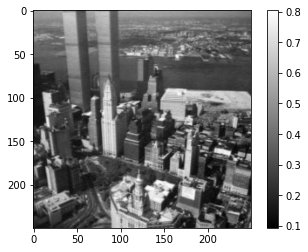

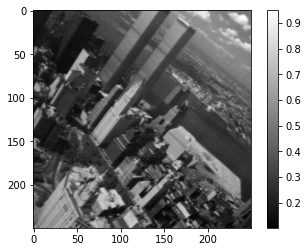

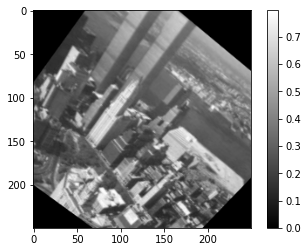

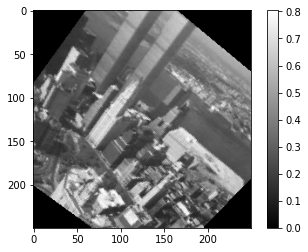

In [ ]:
from numpy.linalg import inv

def reform(Iold,H):
  # x_ = H*x
  # x = H-1 * x_
  I = np.zeros(Iold.shape)
  Hinv = inv(H)
  for x_ in range(len(I[0])):
    for y_ in range(len(I)):
      X_ = np.array([x_,y_,1])
      #x,y,1 = H-1 dot x_,y_,1
      X = Hinv.dot(X_)
      y = int(np.floor(X[1]/X[2]))
      x = int(np.floor(X[0]/X[2]))
      #print(y,x)
      if 0 <= x and x < len(Iold[0]) and 0 <= y and y < len(Iold):
        #print(y_,x_,y,x)
        I[y_,x_] = Iold[y,x]
  return(I)

imshow(Ia)
imshow(Ib)
dst = cv2.warpPerspective(Ia, H, dsize= (Ia.shape[1], Ia.shape[0]))
imshow(dst)

dst = reform(Ia,H)
imshow(dst)